# Image vector search using Azure Cosmos DB for PostgreSQL

## Import libraries

In [1]:
import os
import glob
import json
import psycopg2
from psycopg2 import pool
from dotenv import load_dotenv
import pandas as pd
import csv
from io import StringIO
import math
from azurecv import text_embedding, image_embedding, display_image_grid

## Load image files and embeddings

In [2]:
# images
images_folder = "images"
image_files = glob.glob(images_folder + "/*")

# embeddings
output_folder = "output"
emb_json = os.path.join(output_folder, "embeddings.json")
with open(emb_json) as f:
    image_embeddings = json.load(f)

print(f"Total number of images: {len(image_files)}")
print(f"Number of imported vector embeddings: {len(image_embeddings)}")

Total number of images: 200
Number of imported vector embeddings: 200


In [3]:
df_files = pd.DataFrame(image_files, columns=['file'])
df_embeddings = pd.DataFrame([str(emb) for emb in image_embeddings], columns=['embedding'])
df = pd.concat([df_files, df_embeddings], axis=1)
df.head(5)

,file,embedding
0,images\image (1).jpg,"[0.035308838, -1.3056641, 2.7050781, -0.764648..."
1,images\image (10).jpg,"[2.7851562, -0.24230957, 0.6376953, -0.6367187..."
2,images\image (100).jpg,"[-0.70947266, -0.20019531, 1.6386719, 0.079467..."
3,images\image (101).jpg,"[2.3457031, 1.2509766, 2.765625, 1.9042969, 1...."
4,images\image (102).jpg,"[1.4589844, 2.2148438, -4.4882812, 1.8232422, ..."


## Connect to Azure Cosmos DB for PostgreSQL

In [4]:
# Load environment variables
load_dotenv()
host = os.getenv("POSTGRES_HOST")
dbname = os.getenv("POSTGRES_DB_NAME")
user = os.getenv("POSTGRES_USER")
password = os.getenv("POSTGRES_PASSWORD")
sslmode = "require"
table_name = "imagevectors"

In [5]:
# Build a connection string from the variables
conn_string = "host={0} user={1} dbname={2} password={3} sslmode={4}".format(host, user, dbname, password, sslmode)

In [6]:
postgreSQL_pool = psycopg2.pool.SimpleConnectionPool(1, 20, conn_string)
if (postgreSQL_pool):
    print("Connection pool created successfully")

Connection pool created successfully


In [7]:
# Get a connection from the connection pool
conn = postgreSQL_pool.getconn()
cursor = conn.cursor()

## Add data (image file path and embeddings) to the table

In [8]:
sio = StringIO()
writer = csv.writer(sio)
writer.writerows(df.values)
sio.seek(0)

0

In [9]:
cursor.execute("CREATE TEMPORARY TABLE tmp (file TEXT PRIMARY KEY, embedding VECTOR(1024)) ON COMMIT DROP;")

cursor.copy_expert("COPY tmp FROM STDIN CSV", sio)

cursor.execute(f"""INSERT INTO {table_name} (file, embedding)
                  SELECT * FROM tmp
                  ON conflict (file) DO NOTHING;""")

conn.commit()

### Select the first 10 rows of the table to see the data

In [10]:
# Fetch all rows from table
cursor.execute(f"SELECT * FROM {table_name} limit 10;")
rows = cursor.fetchall()

# Print all rows
for row in rows:
    print(f"Data row = ({row[0]}, {row[1]})")

Data row = (images\image (1).jpg, [0.035308838,-1.3056641,2.7050781,-0.76464844,-0.4128418,0.32055664,2.4902344,2.5898438,1.5419922,-0.54589844,-0.5283203,-2.1386719,3.1816406,-1.9355469,2.046875,-3.6601562,3.0957031,-1.0117188,2.9921875,1.6191406,1.1601562,2.234375,1.0292969,0.114746094,-0.73876953,1.8642578,2.7402344,1.7724609,5.1875,0.5151367,0.93603516,3.671875,0.26953125,1.2324219,1.0029297,1.0126953,0.49926758,-1.7978516,1.8359375,-1.9970703,-3.2519531,-0.7626953,-0.54248047,-2.1484375,4.3554688,0.062683105,-1.2578125,0.7504883,-0.81884766,-6.7148438,-0.5463867,1.3125,1.3144531,-3.9199219,0.39038086,-1.6054688,1.3378906,-0.67041016,-3.3203125,1.3662109,-1.7246094,3.6152344,-1.7539062,0.9038086,-1.9824219,0.3684082,0.109191895,3.1855469,-1.8144531,-1.3056641,0.8671875,6.1835938,0.69921875,-0.9448242,-2.0996094,1.7783203,-1.6347656,-1.4462891,-0.029953003,-2.8183594,0.17541504,-0.8779297,0.8569336,-0.62646484,-1.1777344,-4.7109375,3.4179688,-0.9628906,-0.74365234,-0.22583008,0.7294

## Search images using an image or a text prompt

In [11]:
# Load environment variables
load_dotenv()
endpoint = os.getenv('CV_ENDPOINT') + "computervision/"
key = os.getenv('CV_KEY')

### Test 1: Text-to-image search

In [12]:
# Generate the embedding of the text prompt
txt = "a seahorse"
txt_emb = text_embedding(txt, endpoint, key)

In [21]:
# Vector search
topn = 9
cursor.execute(f"SELECT * FROM {table_name} ORDER BY embedding <=> %s LIMIT {topn}", (str(txt_emb),))

# Display the results
rows = cursor.fetchall()
for row in rows:
    print(row)

('images\\image (35).jpg', '[-1.0195312,-0.40405273,-1.9042969,-1.1708984,1.3867188,-0.13842773,1.1269531,3.046875,-1.3505859,-0.67626953,2.3808594,1.4863281,-0.30810547,-2.0234375,1.0498047,-2.7128906,-0.0418396,0.95458984,-0.46435547,-2.8535156,2.0039062,-0.64160156,3.28125,1.5,1.6484375,-0.4790039,1.8271484,-1.0322266,-3.1484375,-4.2890625,-4.6914062,0.97509766,2.5019531,1.7744141,-2.6308594,3.0625,-5.1132812,2.4082031,-0.19677734,-1.1708984,0.6347656,1.2128906,0.67529297,2.7226562,-2.7832031,2.8671875,-0.20471191,2.7460938,-0.008224487,-6.359375,0.8769531,0.9033203,-0.36279297,-5.2226562,-2.3554688,2.2949219,-0.080200195,3.3183594,1.2099609,1.0625,-5.7617188,-4.28125,-0.56347656,-2.6601562,0.9296875,3.2636719,2.609375,1.109375,1.6699219,-1.6689453,2.0097656,0.79833984,-1.4550781,-3.2578125,-0.59375,-2.3496094,-3.9726562,-0.14587402,-1.7890625,-2.9941406,-2.8066406,-1.6962891,-0.5834961,3.5878906,0.6616211,-5.2226562,-0.08691406,-1.0205078,3.5644531,0.69433594,-2.3300781,-1.890625,-

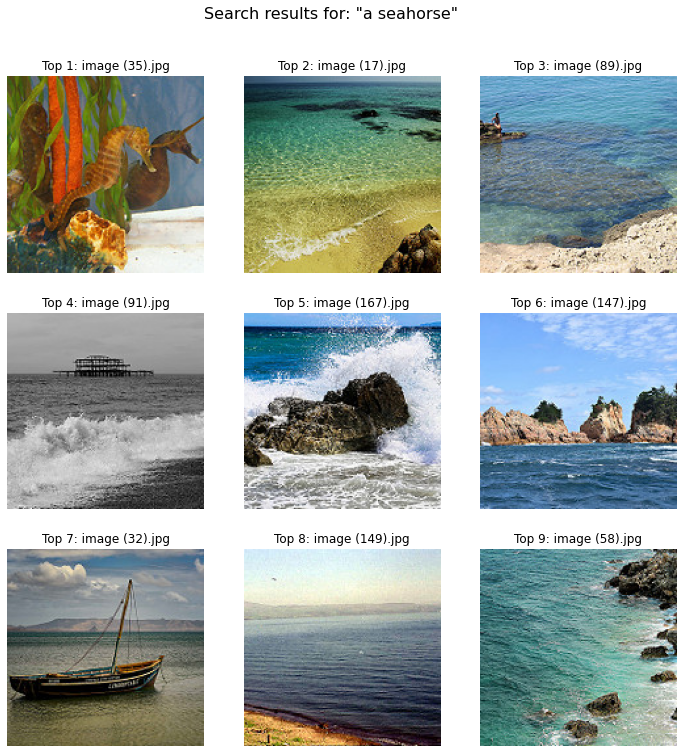

In [22]:
# Display the similar images
images = [row[0] for row in rows]
captions = [f"Top {i+1}: {os.path.basename(images[i])}" for i in range(len(images))]
ncols = 3
nrows = math.ceil(len(images)/ncols)
display_image_grid(images, captions, 'Search results for: "' + txt + '"', nrows, ncols)

### Test 2: Image-to-image search

In [14]:
# Generate the embedding of the reference image
ref_image = "test_images/image (2).jpg"
image_emb = image_embedding(ref_image, endpoint, key)

In [23]:
# Vector search
topn = 11
cursor.execute(f"SELECT * FROM {table_name} ORDER BY embedding <=> %s LIMIT {topn}", (str(image_emb),))

# Display the results
rows = cursor.fetchall()
for row in rows:
    print(row)

('images\\image (7).jpg', '[0.83691406,-0.60302734,0.77197266,0.7915039,2.4140625,1.1777344,-1.0322266,0.48046875,0.42236328,3.3144531,1.2324219,-1.3554688,-3.1210938,-2.7128906,3.1171875,-0.030929565,-1.9765625,-2.8007812,0.13708496,0.5830078,-0.005996704,1.2714844,1.7890625,0.23962402,-0.52783203,-1.2480469,4.1679688,-0.52734375,2.7265625,2.0742188,-2.6992188,1.0673828,-3.390625,-0.8647461,-1.3330078,0.12060547,2.9179688,-0.3774414,0.5395508,-0.82714844,0.6982422,-1.4677734,4.1601562,-0.75927734,0.27368164,2.5253906,-2.59375,-1.1123047,2.1777344,5.421875,-1.7822266,-1.8925781,-0.39672852,-3.4726562,-0.3708496,-0.11651611,4.1953125,-0.90478516,-0.32836914,2.4921875,-3.9921875,0.46118164,-3,0.40039062,2.2128906,1.8222656,-1.8398438,-0.6855469,1.0517578,-3.4238281,-1.7792969,-3.2382812,-0.61035156,0.26245117,-3.6835938,-1.2626953,-0.6635742,2.4707031,-2.296875,2.7617188,1.9833984,-2.4726562,0.6616211,-1.171875,-3.0820312,1.9638672,-1.7314453,0.34399414,1.5771484,-2.1542969,1.1513672,2.8

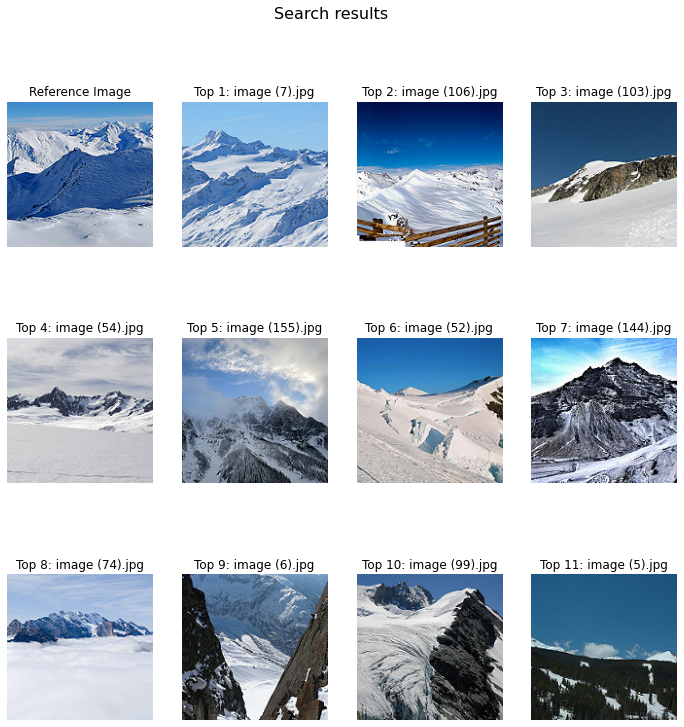

In [24]:
# Display the similar images
images = [row[0] for row in rows]
images.insert(0, ref_image)
captions = [f"Top {i+1}: {os.path.basename(images[i+1])}" for i in range(len(images)-1)]
captions.insert(0, "Reference Image")
ncols = 4
nrows = math.ceil(len(images)/ncols)
display_image_grid(images, captions, 'Search results', nrows, ncols)

## Close the connection

In [25]:
conn.commit()
cursor.close()
conn.close()